## Assignment_1_Data_Analytics
Task: Create python implementations of the procedures from "Balanced Risk Set Matching" by Yunfei Paul Li, Kathleen J. Propert, and Paul R. Rosenbaum

# Contributors
Christian Abay-abay & Thristan Jay Nakila

# Generate Data
Because we don't have access to the original data used in the journal, we generate it and store it into 'synthetic_patient_data.csv'. Note that the journal takes into account Patient ID, Entry Time, Treatment Time, Pain Score, Urgency Score, and Nocturnal Frequency.

In [8]:
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)
n_samples = 400  # Total patients

# Generate patient metadata
patient_ids = np.arange(1, n_samples + 1)
ages = np.random.randint(20, 80, size=n_samples)
genders = np.random.choice(["Male", "Female"], size=n_samples)

enrollment_times = np.random.randint(0, 12, size=n_samples)
treatment_times = np.full(n_samples, np.inf)

treated_flags = np.random.choice([0, 1], size=n_samples)
treatment_delays = np.random.randint(3, 24, size=n_samples)
treatment_times[treated_flags == 1] = enrollment_times[treated_flags == 1] + treatment_delays[treated_flags == 1]

# Generate baseline symptoms
baseline_pain = np.random.randint(1, 10, size=n_samples)
baseline_urgency = np.random.randint(1, 10, size=n_samples)
baseline_frequency = np.random.randint(1, 10, size=n_samples)

# Adjust symptoms post-treatment
treatment_pain = np.clip(baseline_pain + np.random.randint(-2, 3, size=n_samples), 1, 9)
treatment_urgency = np.clip(baseline_urgency + np.random.randint(-2, 3, size=n_samples), 1, 9)
treatment_frequency = np.clip(baseline_frequency + np.random.randint(-2, 3, size=n_samples), 1, 9)

# Follow-up symptom evaluations
pain_3m = np.clip(treatment_pain + np.random.randint(-2, 3, size=n_samples), 1, 9)
urgency_3m = np.clip(treatment_urgency + np.random.randint(-2, 3, size=n_samples), 1, 9)
frequency_3m = np.clip(treatment_frequency + np.random.randint(-2, 3, size=n_samples), 1, 9)

pain_6m = np.clip(pain_3m + np.random.randint(-2, 3, size=n_samples), 1, 9)
urgency_6m = np.clip(urgency_3m + np.random.randint(-2, 3, size=n_samples), 1, 9)
frequency_6m = np.clip(frequency_3m + np.random.randint(-2, 3, size=n_samples), 1, 9)

# Construct DataFrame
data = pd.DataFrame({
    'ID': patient_ids,
    'Age': ages,
    'Gender': genders,
    'Enrollment_Time': enrollment_times,
    'Treatment_Time': treatment_times,
    'Treated': treated_flags,
    'Pain_Baseline': baseline_pain,
    'Urgency_Baseline': baseline_urgency,
    'Frequency_Baseline': baseline_frequency,
    'Pain_Treatment': treatment_pain,
    'Urgency_Treatment': treatment_urgency,
    'Frequency_Treatment': treatment_frequency,
    'Pain_3_Months': pain_3m,
    'Urgency_3_Months': urgency_3m,
    'Frequency_3_Months': frequency_3m,
    'Pain_6_Months': pain_6m,
    'Urgency_6_Months': urgency_6m,
    'Frequency_6_Months': frequency_6m,
})

# Convert Treatment column to categorical labels
data['Treated_Label'] = data['Treated'].map({0: 'Never/Later Treated', 1: 'Treated'})

# Save dataset
csv_path = "./synthetic_patient_data.csv"
data.to_csv(csv_path, index=False)


# Risk Set Matching
The goal of Risk Set Matching is to match the treated patients to similar untreated patients based on the symptoms at the time of treatment. We implement this using Mahalanobis.

In [12]:
import numpy as np
import pandas as pd
from scipy.optimize import linear_sum_assignment
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import mahalanobis
import scipy.linalg

# Load the dataset
data = pd.read_csv("./synthetic_patient_data.csv")

# Filter treated and untreated patients
treated = data[data['Treated'] == 1].copy()
untreated = data[data['Treated'] == 0].copy()

# Define matching criteria: symptoms at the time of treatment
matching_columns = ['Pain_Treatment', 'Urgency_Treatment', 'Frequency_Treatment']

# Standardize the matching variables
scaler = StandardScaler()
treated_scaled = scaler.fit_transform(treated[matching_columns])
untreated_scaled = scaler.transform(untreated[matching_columns])

# Compute covariance matrix and its inverse
cov_matrix = np.cov(np.vstack((treated_scaled, untreated_scaled)).T)
cov_inv = np.linalg.inv(cov_matrix)

# Compute pairwise Mahalanobis distances
distance_matrix = np.array([
    [mahalanobis(t, u, cov_inv) for u in untreated_scaled]
    for t in treated_scaled
])

# Solve the optimal matching using the Hungarian algorithm (integer programming method)
row_ind, col_ind = linear_sum_assignment(distance_matrix)

# Create a DataFrame with matched pairs
matched_pairs = pd.DataFrame({
    'Treated_ID': treated.iloc[row_ind]['ID'].values,
    'Matched_Untreated_ID': untreated.iloc[col_ind]['ID'].values,
    'Matching_Distance': distance_matrix[row_ind, col_ind]
})

# Save matched pairs
matched_pairs.to_csv("./matched_pairs.csv", index=False)

print("Matching completed using Mahalanobis distance and saved to 'matched_pairs.csv'.")


Matching completed using Mahalanobis distance and saved to 'matched_pairs.csv'.


# Balance Checking
Balance checking compares the distribution of features (pain score, urgency score, nocturnal frequency) between treated and matched control groups. We use statistical tests (paired t-tests) to assess balance.

Balance Checking Results:
                     t-statistic   p-value
Pain_Treatment         -0.269662  0.787719
Urgency_Treatment      -0.152880  0.878659
Frequency_Treatment     0.375061  0.708042


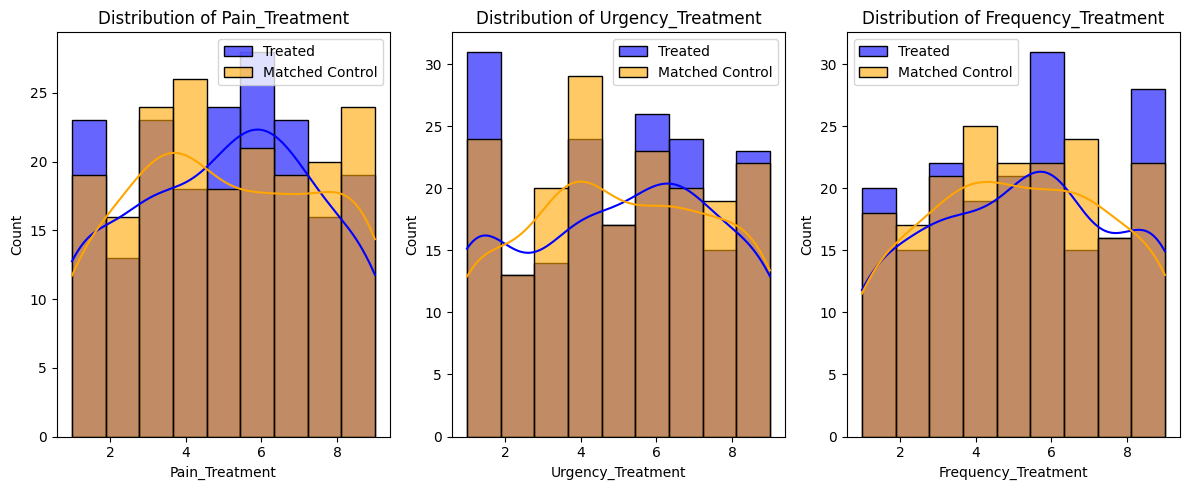

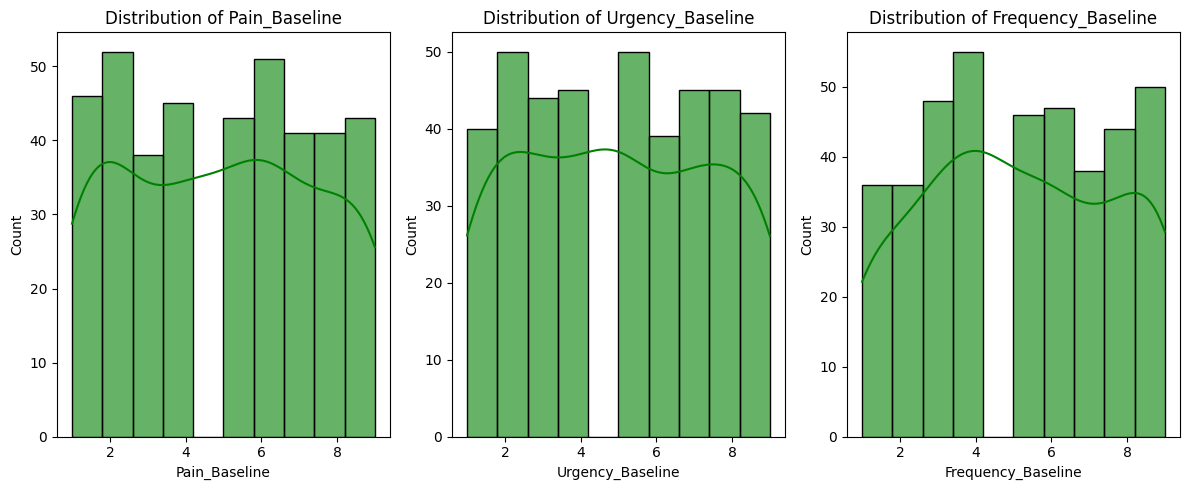

In [13]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
import seaborn as sns

# Load the matched pairs dataset
matched_pairs = pd.read_csv("./matched_pairs.csv")
data = pd.read_csv("./synthetic_patient_data.csv")

# Merge to get full data for matched pairs
treated_matched = data[data['ID'].isin(matched_pairs['Treated_ID'])].copy()
untreated_matched = data[data['ID'].isin(matched_pairs['Matched_Untreated_ID'])].copy()

# Ensure matched data is aligned
treated_matched.sort_values(by='ID', inplace=True)
untreated_matched.sort_values(by='ID', inplace=True)

# Define features for balance checking
balance_features = ['Pain_Treatment', 'Urgency_Treatment', 'Frequency_Treatment']

# Perform paired t-tests
balance_results = {}
for feature in balance_features:
    t_stat, p_value = ttest_rel(treated_matched[feature].values, untreated_matched[feature].values)
    balance_results[feature] = {'t-statistic': t_stat, 'p-value': p_value}

# Convert results to DataFrame
balance_df = pd.DataFrame(balance_results).T
print("Balance Checking Results:")
print(balance_df)

# Visualize distributions before and after matching
plt.figure(figsize=(12, 5))
for i, feature in enumerate(balance_features, 1):
    plt.subplot(1, 3, i)
    sns.histplot(treated_matched[feature], label='Treated', kde=True, color='blue', alpha=0.6)
    sns.histplot(untreated_matched[feature], label='Matched Control', kde=True, color='orange', alpha=0.6)
    plt.title(f"Distribution of {feature}")
    plt.legend()
plt.tight_layout()
plt.show()

# Visualize distributions of baseline symptoms
baseline_features = ['Pain_Baseline', 'Urgency_Baseline', 'Frequency_Baseline']
plt.figure(figsize=(12, 5))
for i, feature in enumerate(baseline_features, 1):
    plt.subplot(1, 3, i)
    sns.histplot(data[feature], kde=True, color='green', alpha=0.6)
    plt.title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()


# Sensitivity Analysis
Sensitivity analysis evaluates how sensitive the treatment effect is to the choice of matched controls. One common approach is to adjust the number of neighbors and examine changes in matched pairs.

In [18]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from scipy.stats import ttest_rel

def sensitivity_analysis(treated, untreated, features, outcome, max_neighbors=5):
    sensitivity_results = {}

    for n_neighbors in range(1, max_neighbors + 1):
        nn = NearestNeighbors(n_neighbors=n_neighbors, metric="euclidean")
        nn.fit(untreated[features])
        distances, indices = nn.kneighbors(treated[features])

        matched_control_ids = untreated.iloc[indices.flatten()]["ID"].values
        matched_df = treated.copy().reset_index(drop=True)

        # Store matched controls per treated patient
        matched_df["Matched_Control_ID"] = [
            matched_control_ids[i : i + n_neighbors] for i in range(0, len(matched_control_ids), n_neighbors)
        ]

        # Compute balance check: Mean difference in features before and after matching
        balance_before = treated[features].mean() - untreated[features].mean()
        matched_controls = untreated.loc[untreated["ID"].isin(matched_control_ids)]
        balance_after = treated[features].mean() - matched_controls[features].mean()

        # Compute treatment effect (Difference in outcome)
        treated_outcome = treated[outcome]
        control_outcome = matched_controls[outcome].mean()  # Averaged over neighbors
        treatment_effect = treated_outcome.mean() - control_outcome.mean()

        # Statistical test for significance of treatment effect
        _, p_value = ttest_rel(treated_outcome, control_outcome)

        sensitivity_results[n_neighbors] = {
            "Matched Pairs": len(matched_control_ids),
            "Balance Before": balance_before.abs().mean(),
            "Balance After": balance_after.abs().mean(),
            "Treatment Effect": treatment_effect,
            "p-value": p_value,
        }

    return pd.DataFrame.from_dict(sensitivity_results, orient="index")

# Run Sensitivity Analysis on Pain Score
sensitivity_results_df = sensitivity_analysis(
    treated, untreated, features=["Pain_Baseline", "Urgency_Baseline", "Frequency_Baseline"], outcome="Pain_3_Months"
)

# Display results
print(sensitivity_results_df)

   Matched Pairs  Balance Before  Balance After  Treatment Effect   p-value
1            187        0.110868       0.038316          0.289820  0.127551
2            374        0.110868       0.078570          0.368279  0.053277
3            561        0.110868       0.084912          0.205075  0.280171
4            748        0.110868       0.094920          0.153298  0.419186
5            935        0.110868       0.093224          0.093824  0.620815


# Outcome Analysis
This examines the outcome after treatment. In this case, we evaluate how matched controls perform compared to treated patients on various health outcomes (pain reduction, urgency reduction)

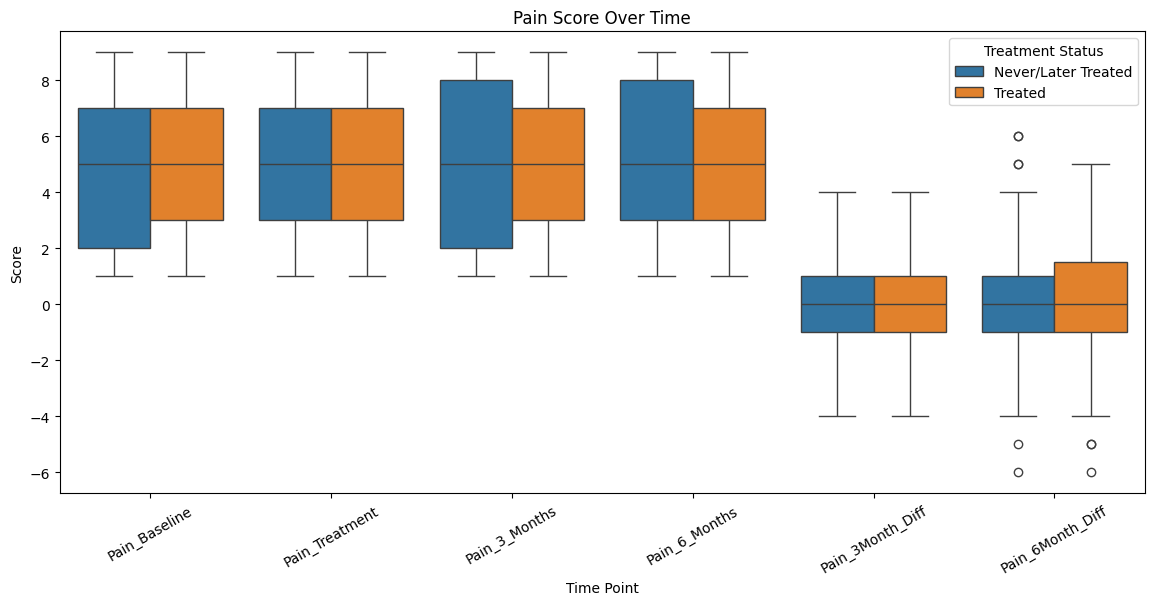

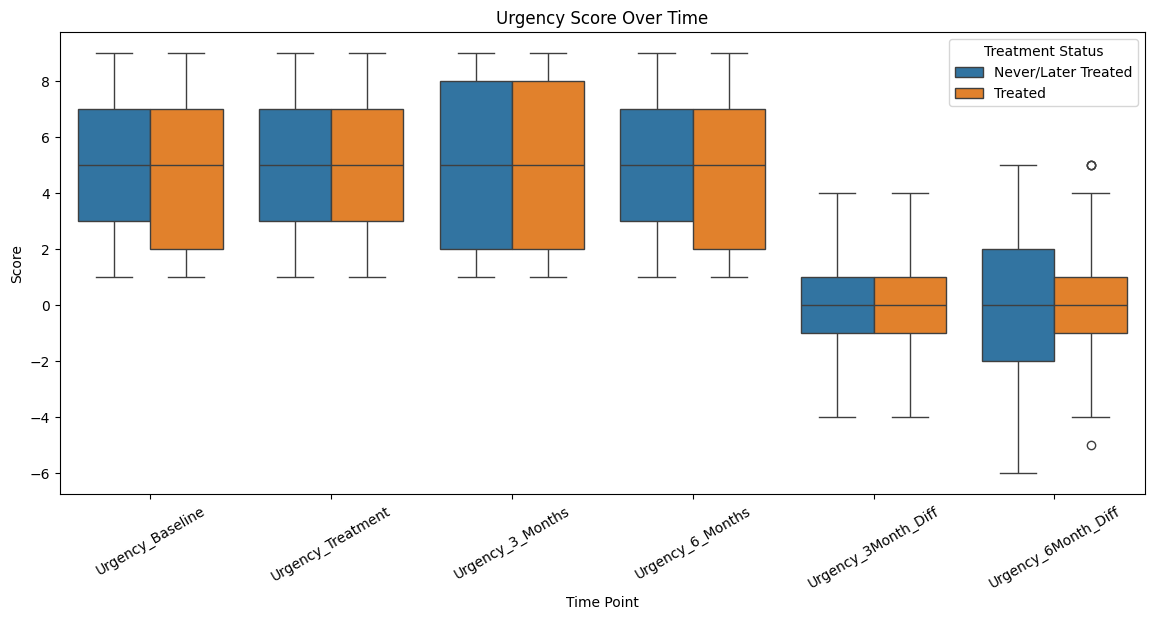

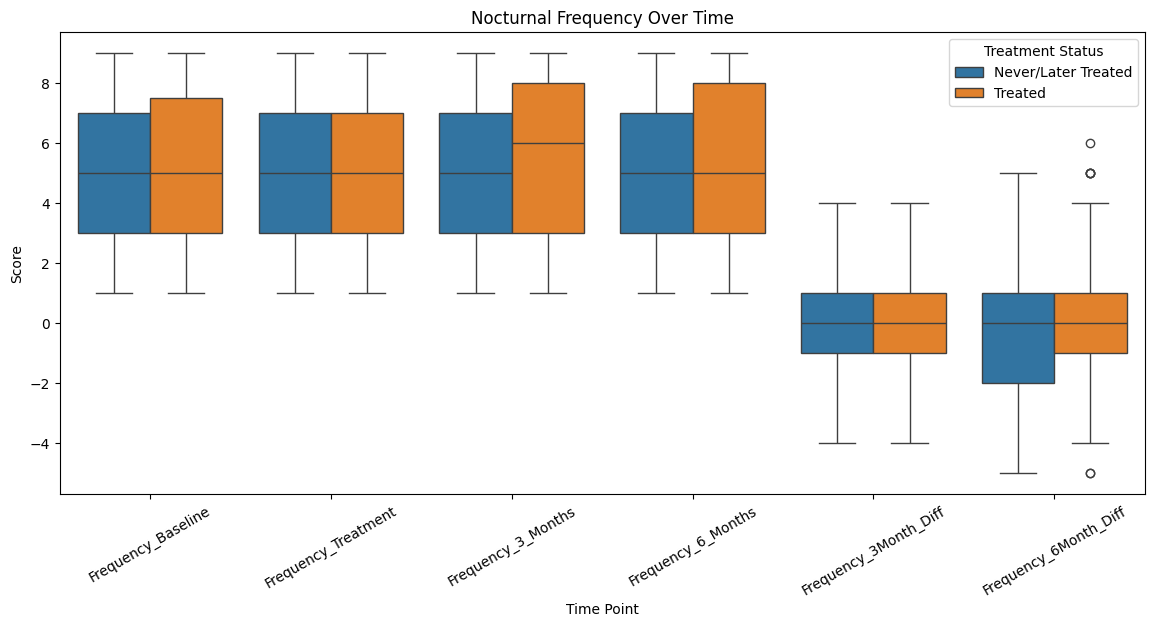

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure treatment status column is categorical
data["Treated_Label"] = data["Treated_Label"].astype(str)

# Compute differences
data["Pain_3Month_Diff"] = data["Pain_3_Months"] - data["Pain_Baseline"]
data["Pain_6Month_Diff"] = data["Pain_6_Months"] - data["Pain_Baseline"]

data["Urgency_3Month_Diff"] = data["Urgency_3_Months"] - data["Urgency_Baseline"]
data["Urgency_6Month_Diff"] = data["Urgency_6_Months"] - data["Urgency_Baseline"]

data["Frequency_3Month_Diff"] = data["Frequency_3_Months"] - data["Frequency_Baseline"]
data["Frequency_6Month_Diff"] = data["Frequency_6_Months"] - data["Frequency_Baseline"]

# Define time points
pain_time_points = [
    "Pain_Baseline", "Pain_Treatment", "Pain_3_Months", "Pain_6_Months",
    "Pain_3Month_Diff", "Pain_6Month_Diff"
]

urgency_time_points = [
    "Urgency_Baseline", "Urgency_Treatment", "Urgency_3_Months", "Urgency_6_Months",
    "Urgency_3Month_Diff", "Urgency_6Month_Diff"
]

frequency_time_points = [
    "Frequency_Baseline", "Frequency_Treatment", "Frequency_3_Months", "Frequency_6_Months",
    "Frequency_3Month_Diff", "Frequency_6Month_Diff"
]

# Function to create boxplots grouped by treatment status
def plot_grouped_boxplots(data, time_points, title):
    melted_data = data.melt(id_vars=["Treated_Label"], value_vars=time_points,
                            var_name="Time Point", value_name="Score")

    plt.figure(figsize=(14, 6))
    sns.boxplot(x="Time Point", y="Score", hue="Treated_Label", data=melted_data)
    plt.xticks(rotation=30)
    plt.title(title)
    plt.ylabel("Score")
    plt.xlabel("Time Point")
    plt.legend(title="Treatment Status")
    plt.show()

# Pain Score Boxplots
plot_grouped_boxplots(data, pain_time_points, "Pain Score Over Time")

# Urgency Score Boxplots
plot_grouped_boxplots(data, urgency_time_points, "Urgency Score Over Time")

# Nocturnal Frequency Boxplots
plot_grouped_boxplots(data, frequency_time_points, "Nocturnal Frequency Over Time")